# Validation of the PyPSA-Earth stats

## Description
This task aims to develop such notebook that:
- takes as input the files from folders from pypsa-earth: `results/{scenarios}/stats.csv` (see PR Create statistics #579). In the meantime, data is loaded from `notebooks/validation/temp_stats_csv/stats_merged_20_3_23.csv`
- loads open data on power systems across the world
- Creates plots to perform the validation
Plots and tables shall have different aggregation levels (e.g. demand for a continent)

Create statistics for:
- demand
- installed capacity by technology (compare with: IRENA, ...)
- renewable sources  (compare with: IRENA, ...)
- network characteristics (length of lines for example)

Plots:
- Compare the statistics of the PyPSA-Earth model with open data

## Public data sources collection
These sources could be helpful:
- [ENTSO-E](https://transparency.entsoe.eu/generation/r2/installedGenerationCapacityAggregation/show)
- [IRENA](https://www.irena.org/data-and-statistics), not working
- [IEA](https://www.iea.org/data-and-statistics)
- [WEC](https://www.worldenergy.org/statistics/), not working
- [WRI](https://www.wri.org/resources/data-sets)
- [UN](https://unstats.un.org/unsd/snaama/)
- [WBG](https://datacatalog.worldbank.org/dataset/world-development-indicators)
- [OECD](https://data.oecd.org/)
- [Eurostat](https://ec.europa.eu/eurostat/data/database)
- [EIA](https://www.eia.gov/outlooks/aeo/data/browser/)
- [Enerdata](https://www.enerdata.net/research/)
- [BP](https://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy.html)
- [USAID](https://www.usaid.gov/what-we-do/energy/global-energy-database), Single countries only?

https://www.usaid.gov/powerafrica/nigeria


## TODO
- DONE: Include continent analysis with country converter coco
- Continent `Asia` shows high ror and low hydro in PyPSA-Earth, but low ror and high hydro in IRENA. Why? Technology mismatch?
- Include stats on how many of the countries of a specific continent are in the PyPSA-Earth model, to better compare continental data. coco could be helpful here

## Questions
- Why are there no coal power plants in `stats_merged.csv`?
- Naming mismatch Hydro (IRENA)?

## Preparation

### Import packages

In [45]:
import logging
import os
import sys

import pypsa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import country_converter as coco

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

In [46]:
nice_names = {
    "nuclear": "Nuclear",
    "oil": "Oil",
    "onwind": "Onshore wind",
    "ror": "Run of river",
    "solar": "Solar PV",
    "hydro": "Hydro",
    "gas": "Gas",
    "coal_and_lignite": "Coal",
}

### Set main directory to root folder

In [47]:
# change current directory
module_path = os.path.abspath(os.path.join('../../../')) # To import helpers

if module_path not in sys.path:
    sys.path.append(module_path+"/pypsa-earth/scripts")
    
from _helpers import sets_path_to_root, country_name_2_two_digits, two_digits_2_name_country

sets_path_to_root("documentation")

This is the repository path:  /mnt/c/Users/scl38887/Documents/git/documentation
Had to go 0 folder(s) up.


### Load stats data (obtained from pypsa-earth)

In [48]:
# Read it with multilevel column names. Make sure that the country index "NA" is not recognized as NaN
stats = pd.read_csv("notebooks/validation/temp_stats_csv/stats_merged_20_3_23.csv", index_col=0, header=[0,1], keep_default_na=False, na_values="")

### Load public data

In [49]:
EXAMPLE_URL="https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/ELECCAP_2022_cycle2.px/"

In [50]:
# Read the data "https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/ELECCAP_2022_cycle2.px/"
# TODO can we download the data directly?
irena_eleccap = pd.read_csv("notebooks/validation/temp_irena/ELECCAP_20230314-165057.csv", encoding="latin-1", skiprows=2)

# Replace ".." in the dataframe with NaN
irena_eleccap = irena_eleccap.replace("..", np.nan)

# Change dtype of column "Installed electricity capacity by country/area (MW)" to float
irena_eleccap["Installed electricity capacity by country/area (MW)"] = irena_eleccap["Installed electricity capacity by country/area (MW)"].astype(float)

In [51]:
# Combine ongrid and offgrid
irena_eleccap = irena_eleccap.groupby(["Country/area", "Year", "Technology"]).sum(numeric_only=True).reset_index() #"Technology", "Installed electricity capacity by country/area (MW)"

# Delete the column "Year" since it is not needed anymore
irena_eleccap = irena_eleccap.drop(columns=["Year"])

In [52]:
# Check data for a single country
irena_eleccap[irena_eleccap["Country/area"] == "Germany"].head(5)

,Country/area,Technology,Installed electricity capacity by country/area (MW)
1482,Germany,Biogas,7611.0
1483,Germany,Coal and peat,0.0
1484,Germany,Fossil fuels n.e.s.,78335.0
1485,Germany,Geothermal energy,40.0
1486,Germany,Liquid biofuels,231.0


## Validation

### Installed capacity by technology

In [53]:
# Define the technologies which should be compared
techs = ["CCGT", "OCGT", "nuclear", "onwind", "solar", "ror",  "hydro", "oil", "coal", "lignite"]

In [54]:
stats.head()

download_osm_data                                                         \
         cables-size generators-size lines-size substations-size total_time   
GR              41.0          8172.0     1189.0            427.0     5.2221   
KR             187.0          3962.0     2968.0            916.0     5.3489   
SZ               1.0            55.0       58.0             28.0     1.6636   
IL              50.0           663.0      799.0            198.0     2.4618   
ID              30.0          1123.0     2425.0           2451.0     6.5828   

                         clean_osm_data                           \
   mean_load max_memory generators-size lines-size lines-size_dc   
GR     77.78     694.51            67.0      997.0           3.0   
KR     71.49     695.32           111.0     3007.0           0.0   
SZ      8.30     461.60             NaN       45.0           0.0   
IL     30.15     611.57            22.0       61.0           0.0   
ID     78.10     773.86           268.0     2143.0           0.0   

                                                                        \
    lines-length lines-length_dc substations-size total_time mean_load   
GR  2.131592e+07   135770.035577           1996.0     7.9456     88.73   
KR  3.476824e+07        0.000000           6111.0    21.9648     71.71   
SZ  6.164592e+05        0.000000             94.0     0.8904      0.00   
IL  1.575221e+06        0.000000            122.0     1.1340      0.00   
ID  5.294945e+07        0.000000           4660.0    68.7576     66.51   

               build_shapes                                           \
   max_memory          area gadm_size country_matching           pop   
GR     529.48  6.257667e+11       8.0            100.0  1.038533e+07   
KR     524.91  5.331273e+11      17.0            100.0  5.133817e+07   
SZ     511.70  2.338520e+10       4.0            100.0  1.161682e+06   
IL     512.00  5.721127e+10       7.0            100.0  8.686033e+06   
ID     526.99  7.979211e+12      34.0            100.0  2.734488e+08   

                                                  \
             gdp total_time mean_load max_memory   
GR  2.917581e+11    32.7742     49.11    1000.40   
KR  2.394653e+12    32.6975     48.35     997.62   
SZ  1.389325e+10    22.2803     71.47    1008.84   
IL  4.187760e+11    23.1516     69.36    1009.09   
ID  2.986296e+12   509.8633    238.17   94265.92   

   build_renewable_profiles_onwind                   build_renewable_profiles  \
                         potential avg_production_pu               total_time   
GR                    1.541671e+05        923.121965                  31.3569   
KR                    1.040942e+05       1278.642517                  37.9565   
SZ                    4.538111e+04        651.710910                   8.9612   
IL                    2.813098e+04        834.927086                  11.3950   
ID                    4.378211e+06        460.769258                  78.2867   

                        build_renewable_profiles_offwind-ac                    \
   mean_load max_memory                           potential avg_production_pu   
GR    126.03   12082.99                        2.951195e+05       1409.545644   
KR    120.84   10647.84                        1.074650e+05       1532.012543   
SZ    193.77    7860.11                                 NaN               NaN   
IL    201.39    9036.75                        1.004099e+04       1007.082141   
ID    211.86   32515.72                        2.301559e+06        557.926606   

   build_renewable_profiles                           \
               total_time.1 mean_load.1 max_memory.1   
GR                  30.2633      130.09     15691.18   
KR                  31.7828      153.98     19129.71   
SZ                  12.2647      160.04      7754.60   
IL                   9.4030      173.32      6951.45   
ID                  86.1980      203.65     43337.71   

   build_renewable_profiles_offwind-dc                

In [55]:
# Select rule "add_electricity" and their techs 
stats_capacities = stats["add_electricity"].loc[:, (techs)]

In [56]:
# Add continent at the beginning of the dataframe
stats_capacities.insert(0, "continent", coco.convert(names = stats_capacities.index, src = 'ISO2', to = 'continent'))

In [57]:
# Replace NaN with zeros
stats_capacities = stats_capacities.fillna(0)

In [58]:
# Combine CCGT and OCGT to "gas"
stats_capacities["gas"] = stats_capacities["CCGT"] + stats_capacities["OCGT"]
stats_capacities["coal_and_lignite"] = stats_capacities["coal"] + stats_capacities["lignite"]
del stats_capacities["CCGT"] 
del stats_capacities["OCGT"] # TODO write in one line
del stats_capacities["coal"] 
del stats_capacities["lignite"]

In [59]:
# Rename to nice plotting names
stats_capacities.rename(columns=nice_names, inplace=True)

In [60]:
stats_capacities.head()

,continent,Nuclear,Onshore wind,Solar PV,Run of river,Hydro,Oil,Gas,Coal
GR,Europe,0.00000,4112.721421,3246.949798,940.970816,3153.114650,3347.852100,3341.886724,4762.852463
KR,Asia,24606.11848,1498.721628,14574.790000,2073.060000,137.821656,5854.440331,31683.149293,30016.403447
SZ,Africa,0.00000,0.000000,0.131667,38.524615,39.292994,0.000000,0.000000,0.000000
IL,Asia,0.00000,26.831003,2230.000000,0.000000,0.000000,4824.355260,4748.080542,4462.174870
ID,Asia,0.00000,144.348258,156.317124,2557.386394,1893.981529,16442.561168,12810.000000,30805.445305


#### Uniform technology names and dataframe structure

In [61]:
# Create dict to match the technology names of stats_capacities and irena eleccap
uniform_names = {"Solar photovoltaic": "solar",
        "Onshore wind energy": "onwind",
        #"Offshore wind energy": "offwind",
        "Renewable hydropower": "hydro",
        "Nuclear": "nuclear",
        "Oil": "oil",
        "Natural gas": "gas",
        "Mixed Hydro Plants": "ror", # TODO Is this correct? Check IRENA    
        "Coal and peat": "coal_and_lignite",
        }

In [62]:
# Rename the technologies in irena_eleccap to match the names in stats_capacities using the dict names
irena_eleccap["Technology"] = irena_eleccap["Technology"].replace(uniform_names)

In [63]:
# Transform technologies to columns and have the countries as index
irena_eleccap = irena_eleccap.pivot_table(index=["Country/area"], columns="Technology", values="Installed electricity capacity by country/area (MW)")
# Reset name of columns
irena_eleccap.columns.name = None

In [64]:
# Change the index of irena_eleccap to two digit country name using the function country_name_2_two_digits()
irena_eleccap.index = irena_eleccap.index.map(country_name_2_two_digits)

In [65]:
# Add continent at the beginning of the dataframe
irena_eleccap.insert(0, "continent", coco.convert(names = irena_eleccap.index, src = 'ISO2', to = 'continent'))

In [66]:
# Rename to nice plotting names
irena_eleccap.rename(columns=nice_names, inplace=True)

In [67]:
# Merge the two dataframes
# merged = pd.merge(stats_capacities, irena_eleccap, left_index=True, right_index=True)

#### Plot country comparison

In [68]:
def plot_barplot(data_stats, data_irena, area):
    # Plot a barplot to compare the technologies of the two dataframes irena_eleccap and stats_capacities

    # Get the index values
    index = np.arange(len(data_stats))
    barWidth = 0.3

    # Create a barplot
    plt.figure(figsize=(10, 4))
    plt.bar(index - barWidth/2, data_stats/1e3, color=['g'], alpha=1, edgecolor='white', width=barWidth) # convert from MW to GW
    plt.bar(index + barWidth/2, data_irena/1e3, color=['g'], alpha=0.3, edgecolor='white', width=barWidth) # convert from MW to GW

    # Enhance graph
    plt.xticks(index, data_stats.index)
    plt.ylabel("Capacity in GW")
    plt.legend(["PyPSA-Earth", "IRENA"], loc='upper left', ncol=1)

    plt.grid(axis='y', alpha=0.5)
    plt.title(f"Electric capacity in {area}")

    # Show graphic & save it
    plt.show()
    #plt.savefig("file", bbox_inches='tight') # TODO add save path
    
    return

In [69]:
def is_country_or_continent(area_name):

    # Check if the area name is a valid ISO-3166 country code

    area_name = coco.convert(names=area_name, to='name_short')
    if area_name != "not found":
        return "country"
    else:
        return "continent" # TODO all invalid names are continents, this should be improved


In [70]:
def data_selection(area, stats_capacities, irena_eleccap):

    _stats_capacities = stats_capacities.copy()
    _irena_eleccap = irena_eleccap.copy()

    if is_country_or_continent(area) == "continent":

        # Group the data by continent if area is "continent"
        _irena_eleccap = _irena_eleccap.groupby("continent").sum()
        _stats_capacities = _stats_capacities.groupby("continent").sum()

    elif is_country_or_continent(area) == "country":
        try:
            _irena_eleccap.drop(columns=["continent"], inplace=True)
            _stats_capacities.drop(columns=["continent"], inplace=True)
        except:
            pass

    # Select the data for the area
    data_irena = _irena_eleccap.loc[area][_stats_capacities.loc[area].index]
    data_stats = _stats_capacities.loc[area]

    return data_stats, data_irena

### Plot comparison (both country or continent possible)

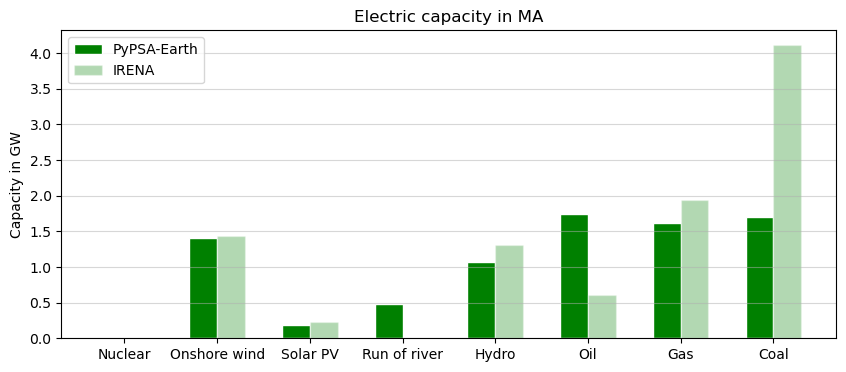

In [73]:
area = "MA"
data_stats, data_irena = data_selection(area, stats_capacities, irena_eleccap)
plot_barplot(data_stats, data_irena, area)

### Demand